In [8]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import numpy as np

from linearmodels.panel import PanelOLS
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Characteristics OLS

Professor said we should start with a regular OLS Regression.
I quickly looked into this and think a random effects panel regression would probably fit our data better (still need to read more into this)
So probably we can first do a regular OLS and than compare it to the random effects panel regression. Just some initial thoughts though!!!
Here is some intial code to run them:


In [9]:
#decide which df to use
df = pd.read_csv("Dataframes/characteristics.csv")
#df = df.loc[:, ["Instrument", "Date", "Earnings Per Share - Actual Surprise", "Revenue - Actual", "Net Income after Tax"]]
X_var_names = ["Revenue - Actual","Enterprise Value","Market Capitalization","loss firm status", "Enterprise Value To Sales (Daily Time Series Ratio)", "3 Month Total Return", "Volume"]
df

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,Earnings Per Share - Actual Surprise AbsVals,Revenue - Actual,Enterprise Value,Market Capitalization,Enterprise Value To Sales (Daily Time Series Ratio),3 Month Total Return,Volume,loss firm status
0,AVY.N,2013-01-01,Materials,11.178,11.178,1.532200e+09,4.413001e+09,3.426001e+09,0.799347,10.637479,207295.0,-1
1,AVY.N,2013-04-01,Materials,2.482,2.482,1.498900e+09,5.459128e+09,4.309428e+09,0.895787,24.148726,0.0,-1
2,AVY.N,2013-07-01,Materials,1.068,1.068,1.552300e+09,5.436229e+09,4.258229e+09,0.906078,-0.054218,0.0,-1
3,AVY.N,2013-10-01,Materials,8.095,8.095,1.504900e+09,5.029514e+09,4.273414e+09,0.903176,2.467620,236291.0,-1
4,AVY.N,2014-01-01,Materials,1.471,1.471,1.583900e+09,5.553068e+09,4.877168e+09,0.920659,16.003852,157761.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
19299,POOL.OQ,2021-10-01,Retailing,17.194,17.194,1.411448e+09,1.769954e+10,1.742020e+10,3.684400,-5.130322,157740.0,-1
19300,POOL.OQ,2022-01-01,Retailing,40.267,40.267,1.035557e+09,2.384882e+10,2.268979e+10,4.504382,30.489705,82349.0,-1
19301,POOL.OQ,2022-04-01,Retailing,34.342,34.342,1.412650e+09,1.843682e+10,1.696712e+10,3.422880,-25.160664,290897.0,-1
19302,POOL.OQ,2022-07-01,Retailing,1.503,1.503,2.055818e+09,1.556187e+10,1.405795e+10,2.749481,-21.661570,185584.0,-1


#### OLS Regression

In [10]:
#identifying outliers and replacing them with NA
summary_stats = df["Earnings Per Share - Actual Surprise"].describe()
Q1 = summary_stats.loc['25%']
Q3 = summary_stats.loc['75%']
IQR = Q3 - Q1
threshold = 7 #1.5 is standard threshold but we still want to keep enough variation in the data so setting threshol higher here
surprise_outliers_removed = df["Earnings Per Share - Actual Surprise"].loc[~((df["Earnings Per Share - Actual Surprise"] < (Q1 - threshold * IQR)) | (df["Earnings Per Share - Actual Surprise"] > (Q3 + threshold * IQR)))]
df_accuracy_new = df.copy()
df_accuracy_new["Earnings Per Share - Actual Surprise"] = surprise_outliers_removed
df_accuracy_new = df_accuracy_new.dropna(subset=["Earnings Per Share - Actual Surprise"])
#df_accuracy_new["Recommendation - Mean (1-5)"] = df_accuracy_new["Recommendation - Mean (1-5)"].fillna(0)
df_accuracy_new = df_accuracy_new.dropna()
df_accuracy_new.value_counts("loss firm status")


loss firm status
-1    17252
 1     1271
 0       10
dtype: int64

In [11]:
df_accuracy_new

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,Earnings Per Share - Actual Surprise AbsVals,Revenue - Actual,Enterprise Value,Market Capitalization,Enterprise Value To Sales (Daily Time Series Ratio),3 Month Total Return,Volume,loss firm status
0,AVY.N,2013-01-01,Materials,11.178,11.178,1.532200e+09,4.413001e+09,3.426001e+09,0.799347,10.637479,207295.0,-1
1,AVY.N,2013-04-01,Materials,2.482,2.482,1.498900e+09,5.459128e+09,4.309428e+09,0.895787,24.148726,0.0,-1
2,AVY.N,2013-07-01,Materials,1.068,1.068,1.552300e+09,5.436229e+09,4.258229e+09,0.906078,-0.054218,0.0,-1
3,AVY.N,2013-10-01,Materials,8.095,8.095,1.504900e+09,5.029514e+09,4.273414e+09,0.903176,2.467620,236291.0,-1
4,AVY.N,2014-01-01,Materials,1.471,1.471,1.583900e+09,5.553068e+09,4.877168e+09,0.920659,16.003852,157761.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
19299,POOL.OQ,2021-10-01,Retailing,17.194,17.194,1.411448e+09,1.769954e+10,1.742020e+10,3.684400,-5.130322,157740.0,-1
19300,POOL.OQ,2022-01-01,Retailing,40.267,40.267,1.035557e+09,2.384882e+10,2.268979e+10,4.504382,30.489705,82349.0,-1
19301,POOL.OQ,2022-04-01,Retailing,34.342,34.342,1.412650e+09,1.843682e+10,1.696712e+10,3.422880,-25.160664,290897.0,-1
19302,POOL.OQ,2022-07-01,Retailing,1.503,1.503,2.055818e+09,1.556187e+10,1.405795e+10,2.749481,-21.661570,185584.0,-1


C:\Users\alexa\AppData\Local\Temp\ipykernel_28864\3131907231.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = for_rf.corr()


<AxesSubplot: >

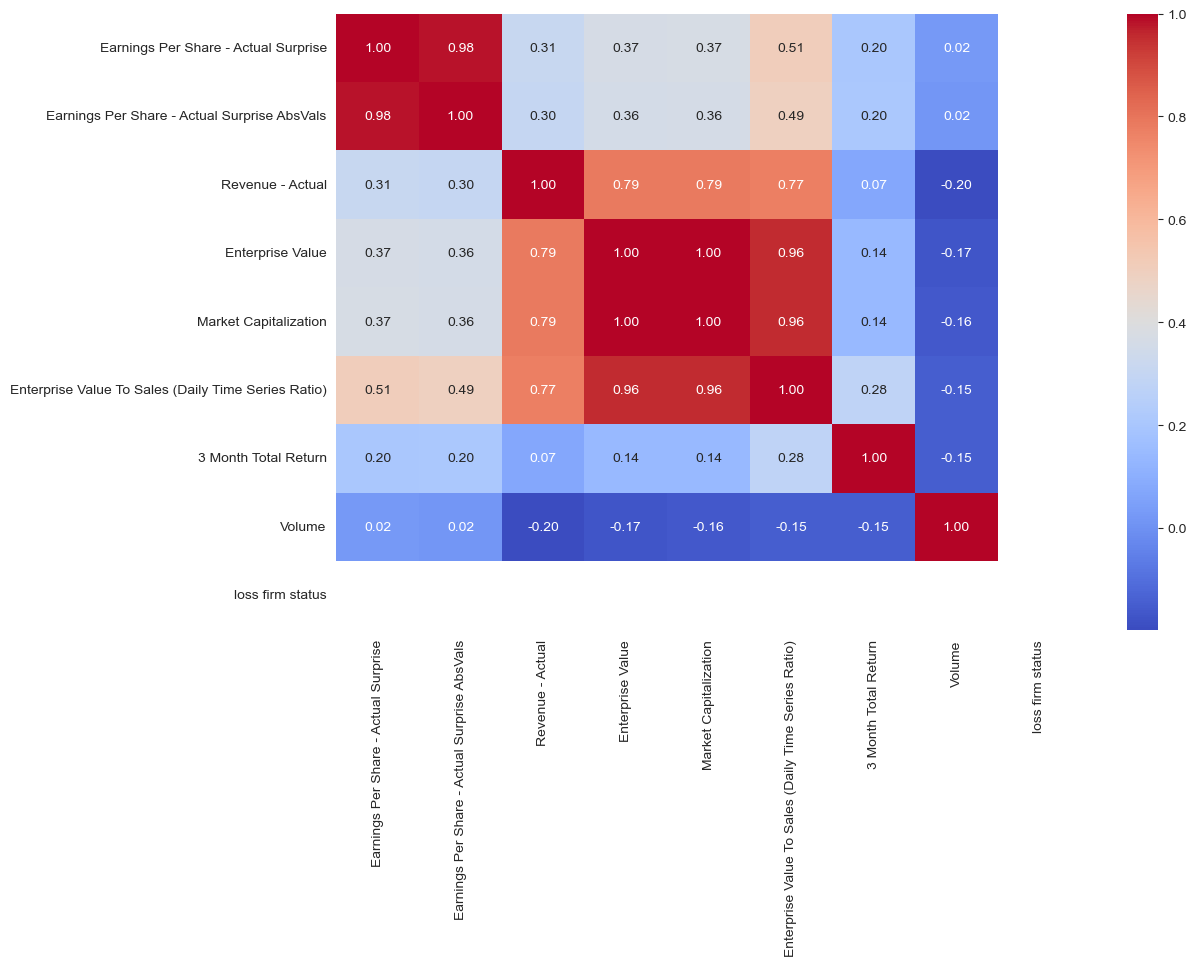

In [12]:
#for_rf = df_accuracy_new.iloc[:25,:]
for_rf = df_accuracy_new[df_accuracy_new['Instrument'] == 'AAPL.OQ']
#.iloc[0:38, :]


# print the reversed DataFrame
for_rf

corr_matrix = for_rf.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [6]:
rescale = df_accuracy_new
#rescale["Earnings Per Share - Actual Surprise"] = MinMaxScaler().fit_transform(np.array(rescale["Earnings Per Share - Actual Surprise"]).reshape(-1,1))
rescale["Revenue - Actual"] = MinMaxScaler().fit_transform(np.array(rescale["Revenue - Actual"]).reshape(-1,1))
rescale["Enterprise Value"] = MinMaxScaler().fit_transform(np.array(rescale["Enterprise Value"]).reshape(-1,1))
rescale["Market Capitalization"] = MinMaxScaler().fit_transform(np.array(rescale["Market Capitalization"]).reshape(-1,1))
rescale["Enterprise Value To Sales (Daily Time Series Ratio)"] = MinMaxScaler().fit_transform(np.array(rescale["Enterprise Value To Sales (Daily Time Series Ratio)"]).reshape(-1,1))
rescale["3 Month Total Return"] = MinMaxScaler().fit_transform(np.array(rescale["3 Month Total Return"]).reshape(-1,1))
rescale["Volume"] = MinMaxScaler().fit_transform(np.array(rescale["Volume"]).reshape(-1,1))

rescale

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,Revenue - Actual,Enterprise Value,Market Capitalization,Enterprise Value To Sales (Daily Time Series Ratio),3 Month Total Return,Volume,loss firm status
0,AVY.N,2013-01-01,Materials,11.178,0.065123,0.027862,0.001166,0.027195,0.298034,0.001183,-1
1,AVY.N,2013-04-01,Materials,2.482,0.064917,0.028207,0.001471,0.027308,0.340793,0.000000,-1
2,AVY.N,2013-07-01,Materials,1.068,0.065247,0.028199,0.001453,0.027321,0.264198,0.000000,-1
3,AVY.N,2013-10-01,Materials,8.095,0.064955,0.028065,0.001459,0.027317,0.272179,0.001348,-1
4,AVY.N,2014-01-01,Materials,1.471,0.065443,0.028238,0.001667,0.027338,0.315017,0.000900,-1
...,...,...,...,...,...,...,...,...,...,...,...
19335,POOL.OQ,2021-10-01,Retailing,17.194,0.064377,0.032245,0.006004,0.030598,0.248134,0.000900,-1
19336,POOL.OQ,2022-01-01,Retailing,40.267,0.062055,0.034274,0.007826,0.031566,0.360861,0.000470,-1
19337,POOL.OQ,2022-04-01,Retailing,34.342,0.064385,0.032488,0.005848,0.030290,0.184744,0.001660,-1
19338,POOL.OQ,2022-07-01,Retailing,1.503,0.068358,0.031540,0.004842,0.029495,0.195817,0.001059,-1


In [7]:
y = rescale["Earnings Per Share - Actual Surprise"]
#X = df_accuracy_new[['Revenue - Actual', 'Net Income after Tax']]
X = rescale[X_var_names]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Earnings Per Share - Actual Surprise   R-squared:                       0.014
Model:                                              OLS   Adj. R-squared:                  0.013
Method:                                   Least Squares   F-statistic:                     36.59
Date:                                  Sun, 26 Feb 2023   Prob (F-statistic):           3.21e-51
Time:                                          18:50:07   Log-Likelihood:                -78910.
No. Observations:                                 18569   AIC:                         1.578e+05
Df Residuals:                                     18561   BIC:                         1.579e+05
Df Model:                                             7                                         
Covariance Type:                              nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -4.5474      0.907     -5.013      0.000      -6.326      -2.769
Revenue - Actual                                       -0.6586      2.182     -0.302      0.763      -4.936       3.619
Enterprise Value                                       13.1458     11.428      1.150      0.250      -9.254      35.545
Market Capitalization                                  -4.4204     11.113     -0.398      0.691     -26.203      17.362
loss firm status                                       -0.0899      0.248     -0.363      0.717      -0.576       0.396
Enterprise Value To Sales (Daily Time Series Ratio)   -14.8024     10.119     -1.463      0.144     -34.636       5.031
3 Month Total Return                                   41.1506      2.656     15.496      0.000      35.945      46.356
Volume                                                 13.9073      7.903      1.760      0.078      -1.584      29.398
==============================================================================
Omnibus:                     3753.199   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33490.865
Skew:                           0.719   Prob(JB):                         0.00
Kurtosis:                       9.420   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### OLS Pooled Regression

In [8]:
df_accuracy_new['Date'] = pd.to_datetime(df_accuracy_new['Date'], infer_datetime_format=True)
df_accuracy_new.dtypes

Instrument                                                     object
Date                                                   datetime64[ns]
GICS Industry Group Name                                       object
Earnings Per Share - Actual Surprise                          float64
Revenue - Actual                                              float64
Enterprise Value                                              float64
Market Capitalization                                         float64
Enterprise Value To Sales (Daily Time Series Ratio)           float64
3 Month Total Return                                          float64
Volume                                                        float64
loss firm status                                                int64
dtype: object

In [9]:
#df_accuracy_new.set_index(["Instrument", "Date"], inplace=True)
df_accuracy_new

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,Revenue - Actual,Enterprise Value,Market Capitalization,Enterprise Value To Sales (Daily Time Series Ratio),3 Month Total Return,Volume,loss firm status
0,AVY.N,2013-01-01,Materials,11.178,0.065123,0.027862,0.001166,0.027195,0.298034,0.001183,-1
1,AVY.N,2013-04-01,Materials,2.482,0.064917,0.028207,0.001471,0.027308,0.340793,0.000000,-1
2,AVY.N,2013-07-01,Materials,1.068,0.065247,0.028199,0.001453,0.027321,0.264198,0.000000,-1
3,AVY.N,2013-10-01,Materials,8.095,0.064955,0.028065,0.001459,0.027317,0.272179,0.001348,-1
4,AVY.N,2014-01-01,Materials,1.471,0.065443,0.028238,0.001667,0.027338,0.315017,0.000900,-1
...,...,...,...,...,...,...,...,...,...,...,...
19335,POOL.OQ,2021-10-01,Retailing,17.194,0.064377,0.032245,0.006004,0.030598,0.248134,0.000900,-1
19336,POOL.OQ,2022-01-01,Retailing,40.267,0.062055,0.034274,0.007826,0.031566,0.360861,0.000470,-1
19337,POOL.OQ,2022-04-01,Retailing,34.342,0.064385,0.032488,0.005848,0.030290,0.184744,0.001660,-1
19338,POOL.OQ,2022-07-01,Retailing,1.503,0.068358,0.031540,0.004842,0.029495,0.195817,0.001059,-1


# with grouping


In [10]:
df_accuracy_new

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,Revenue - Actual,Enterprise Value,Market Capitalization,Enterprise Value To Sales (Daily Time Series Ratio),3 Month Total Return,Volume,loss firm status
0,AVY.N,2013-01-01,Materials,11.178,0.065123,0.027862,0.001166,0.027195,0.298034,0.001183,-1
1,AVY.N,2013-04-01,Materials,2.482,0.064917,0.028207,0.001471,0.027308,0.340793,0.000000,-1
2,AVY.N,2013-07-01,Materials,1.068,0.065247,0.028199,0.001453,0.027321,0.264198,0.000000,-1
3,AVY.N,2013-10-01,Materials,8.095,0.064955,0.028065,0.001459,0.027317,0.272179,0.001348,-1
4,AVY.N,2014-01-01,Materials,1.471,0.065443,0.028238,0.001667,0.027338,0.315017,0.000900,-1
...,...,...,...,...,...,...,...,...,...,...,...
19335,POOL.OQ,2021-10-01,Retailing,17.194,0.064377,0.032245,0.006004,0.030598,0.248134,0.000900,-1
19336,POOL.OQ,2022-01-01,Retailing,40.267,0.062055,0.034274,0.007826,0.031566,0.360861,0.000470,-1
19337,POOL.OQ,2022-04-01,Retailing,34.342,0.064385,0.032488,0.005848,0.030290,0.184744,0.001660,-1
19338,POOL.OQ,2022-07-01,Retailing,1.503,0.068358,0.031540,0.004842,0.029495,0.195817,0.001059,-1


In [11]:
from statsmodels.iolib.summary2 import summary_col
# Split the DataFrame into groups based on the stocks
df = df_accuracy_new[df_accuracy_new['GICS Industry Group Name'] == 'Technology Hardware & Equipment']
groups = df.groupby('Instrument')

# Define a function to perform OLS regression on each group
def ols_regression(group):
    # Define the dependent and independent variables
    if len(group) < 2:
        return None
    y = group['Earnings Per Share - Actual Surprise']
    X = group[X_var_names]

    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Fit the OLS model and return the results
    model = sm.OLS(y, X).fit()
    return model

# Apply the function to each group of data
results = groups.apply(ols_regression)
results = results.dropna()
# Collect the results into a new DataFrame

# Print the coefficients, t-values, and p-values
# print('Coefficients:')
# print(coefficients)
# print('\nT-values:')
# print(t_values)
# print('\nP-values:')
models = results.tolist()
summary = summary_col(models, stars=True, float_format='%0.2f', model_names=results.index.tolist())

# Print the combined summary table
summary

,AAPL.OQ,ANET.N,APH.N,CDW.OQ,CSCO.OQ,FFIV.OQ,GLW.N,HPE.N,HPQ.N,JNPR.N,KEYS.N,MSI.N,NTAP.OQ,STX.OQ,TDY.N,TEL.N,TRMB.OQ,WDC.OQ,ZBRA.OQ
3 Month Total Return,-24.26,-2.31,83.47***,17.37,6.74,-5.71,30.99,168.80**,12.37,87.89,-28.94,-40.72,18.68,32.33,-5.33,74.26**,56.68,76.51,-6.79
,(27.53),(24.30),(29.13),(32.93),(15.20),(14.63),(32.83),(68.72),(30.41),(52.43),(64.61),(65.43),(47.58),(34.74),(71.97),(31.09),(43.42),(50.74),(37.86)
Enterprise Value,-21.25,15991.18,-4666.85,-5801.69,433.93,16461.96*,-1147.78,-6843.77,-5606.01**,-19215.84,6185.46,-1210.53,15125.55,-6107.04,29882.56**,3176.43,12242.56,-5106.23,91.44
,(199.94),(12656.25),(6558.33),(5450.74),(259.85),(9324.04),(2041.77),(7435.86),(2516.79),(12155.60),(26494.73),(4528.87),(10071.03),(8759.73),(12444.40),(4814.64),(18401.71),(3999.33),(16597.45)
Enterprise Value To Sales (Daily Time Series Ratio),8575.90***,3322.39**,5395.66,-46370.26*,-1452.53,839.48,2248.96,-13763.41,1524.86,8590.34,229.87,959.98,-4933.07,18905.37,8986.12**,2265.71,3255.81,4079.30,4192.34
,(2275.37),(1298.51),(3736.59),(22839.27),(1667.50),(2775.86),(4740.30),(21160.25),(2058.15),(15416.97),(4606.56),(6907.51),(10627.85),(12251.02),(4402.26),(4624.53),(5995.43),(14495.48),(3387.88)
Market Capitalization,-31.55,-19942.13*,1888.29,13114.97**,-387.48,-18519.32**,-1581.40,8103.57,2707.09,9669.85,-5362.61,766.61,-12332.26,-2891.86,-32721.40***,-3192.90,-15415.73,5130.31,-3254.45
,(198.99),(10797.83),(6856.99),(5417.13),(245.41),(8454.05),(1626.15),(6223.70),(2049.69),(5729.65),(23638.87),(4100.90),(8287.99),(8107.21),(10064.28),(4633.42),(15573.34),(3903.07),(13326.10)
R-squared,0.43,0.56,0.44,0.25,0.22,0.29,0.17,0.48,0.39,0.41,0.20,0.24,0.26,0.42,0.32,0.68,0.20,0.23,0.15
R-squared Adj.,0.32,0.43,0.34,0.06,0.08,0.16,-0.02,0.29,0.26,0.28,-0.04,0.07,0.10,0.30,0.20,0.61,0.02,0.07,-0.04
